# Clasificación Cuántica de Sonidos Respiratorios

## Detección de EPOC mediante Aprendizaje Automático Cuántico

---

**Autor:** Alejandro Moris Lara  
**Asignatura:** Temas Avanzados de Ciencia e Ingeniería de Datos  
**Fecha:** Diciembre 2024

---

### Resumen

Este trabajo presenta un estudio comparativo de técnicas de Aprendizaje Automático Cuántico (QML) para la clasificación binaria de sonidos respiratorios, distinguiendo entre pacientes sanos y pacientes con Enfermedad Pulmonar Obstructiva Crónica (EPOC). Se implementan y evalúan tres enfoques cuánticos: Quantum Support Vector Machines (QSVM), Redes Neuronales Cuánticas (QNN) y redes híbridas cuántico-clásicas, comparándolos con un baseline clásico basado en SVM.

---

### Tabla de Contenidos

1. [Introducción](#1-introducción)
2. [Objetivos](#2-objetivos)
3. [Selección y Estudio del Dataset](#3-selección-y-estudio-del-dataset)
4. [Preparación de los Datos](#4-preparación-de-los-datos)
   - 4.4 Tratamiento del Desbalance de Clases (SMOTE)
5. [Metodología](#5-metodología)
   - 5.4 Técnicas de Regularización y Control de Overfitting
6. [Modelos de Clasificación](#6-modelos-de-clasificación)
   - 6.1 Baseline Clásico: SVM
   - 6.2 Quantum Support Vector Machine (QSVM)
   - 6.3 Red Neuronal Cuántica (QNN)
   - 6.4 Red Híbrida Cuántico-Clásica
7. [Resultados](#7-resultados)
8. [Conclusiones](#8-conclusiones)


---

## 1. Introducción

La Enfermedad Pulmonar Obstructiva Crónica (EPOC) representa uno de los principales desafíos de salud pública a nivel mundial, siendo la tercera causa de muerte según la Organización Mundial de la Salud. Esta enfermedad respiratoria crónica se caracteriza por una limitación persistente del flujo de aire, generalmente progresiva, y se asocia a una respuesta inflamatoria crónica de las vías aéreas y los pulmones ante la exposición a partículas o gases nocivos.

El diagnóstico temprano de la EPOC es fundamental para mejorar el pronóstico de los pacientes, ya que permite iniciar tratamientos que ralentizan la progresión de la enfermedad. Tradicionalmente, el diagnóstico se realiza mediante espirometría, una prueba que requiere equipamiento especializado y personal médico capacitado. Sin embargo, la auscultación pulmonar mediante estetoscopio constituye un método de cribado accesible y no invasivo que puede identificar patrones sonoros característicos de enfermedades respiratorias.

En este contexto, el Aprendizaje Automático Cuántico (Quantum Machine Learning, QML) emerge como un paradigma prometedor que combina las capacidades del aprendizaje automático clásico con las propiedades únicas de la computación cuántica, como la superposición y el entrelazamiento. Estas propiedades permiten, en teoría, explorar espacios de características de alta dimensionalidad de manera más eficiente que los métodos clásicos.

El presente trabajo explora la aplicación de tres técnicas de QML para la clasificación automática de sonidos respiratorios:

- **Quantum Support Vector Machines (QSVM)**: Utilizan kernels cuánticos para mapear datos a espacios de Hilbert de alta dimensión.
- **Redes Neuronales Cuánticas (QNN)**: Emplean circuitos cuánticos parametrizados optimizados mediante gradientes.
- **Redes Híbridas Cuántico-Clásicas**: Combinan capas neuronales clásicas con capas cuánticas variacionales.


---

## 2. Objetivos

### 2.1 Objetivo General

Desarrollar y evaluar modelos de clasificación cuántica para la detección automática de EPOC a partir del análisis de sonidos respiratorios, comparando su rendimiento con técnicas de aprendizaje automático clásico.

### 2.2 Objetivos Específicos

1. **Preparar y analizar el conjunto de datos**: Seleccionar un dataset de sonidos respiratorios real, extraer características acústicas relevantes y preparar los datos para su uso en algoritmos cuánticos.

2. **Implementar un clasificador QSVM**: Diseñar un kernel cuántico que capture relaciones no lineales entre características acústicas y evaluar su capacidad discriminativa.

3. **Desarrollar una QNN**: Construir un circuito cuántico variacional con embedding de ángulo y ansatz entrelazado, optimizando sus parámetros mediante descenso de gradiente.

4. **Crear una red híbrida cuántico-clásica**: Diseñar una arquitectura que combine preprocesamiento clásico, una capa cuántica y postprocesamiento clásico para la clasificación.

5. **Comparar y analizar resultados**: Realizar una comparativa rigurosa de todos los modelos en términos de métricas de clasificación médica, tiempos de entrenamiento y viabilidad práctica.


---

## 3. Selección y Estudio del Dataset

### 3.1 Procedencia de los Datos

Para este estudio se utiliza el **ICBHI 2017 Respiratory Sound Database**, un conjunto de datos de referencia en el campo del análisis de sonidos respiratorios. Este dataset fue creado para el Scientific Challenge de la International Conference on Biomedical Health Informatics (ICBHI) de 2017 y está disponible públicamente a través de Kaggle.

El dataset contiene grabaciones de sonidos respiratorios adquiridos mediante estetoscopios digitales en diferentes ubicaciones del tórax (anterior, posterior y lateral) de pacientes con diversas condiciones pulmonares. Las grabaciones fueron recopiladas en dos instituciones médicas de Portugal y Grecia.

### 3.2 Descripción del Dataset

El dataset original comprende:

| Característica | Valor |
|---------------|-------|
| Total de archivos de audio | 920 |
| Número de pacientes | 126 |
| Diagnósticos incluidos | Healthy, COPD, URTI, LRTI, Asthma, Bronchiectasis, Pneumonia, Bronchiolitis |
| Duración total | ~5.5 horas |
| Frecuencia de muestreo | 4000-44100 Hz |

Para el presente trabajo, se realiza una **clasificación binaria** entre:
- **Clase 0 (Healthy)**: Pacientes sanos sin patología respiratoria
- **Clase 1 (COPD)**: Pacientes diagnosticados con Enfermedad Pulmonar Obstructiva Crónica

Esta selección responde a la relevancia clínica de la EPOC y a la necesidad de un problema de clasificación binaria compatible con las limitaciones actuales de los simuladores cuánticos.



In [1]:
import sys
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config.settings import N_QUBITS, N_QUBITS_HYBRID, CLASS_NAMES, RANDOM_STATE
from config.paths import PROCESSED_DATA_DIR, RESULTS_DIR

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"Directorio del proyecto: {project_root}")


Directorio del proyecto: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database


In [2]:
features_path = PROCESSED_DATA_DIR / "features.csv"
df = pd.read_csv(features_path)

print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"Número total de muestras: {len(df)}")
print(f"Número de pacientes únicos: {df['patient_id'].nunique()}")
print(f"Número de características: {len([c for c in df.columns if 'mfcc' in c])}")
print(f"\nColumnas del dataset:")
print(df.columns.tolist()[:10], "...")


INFORMACIÓN DEL DATASET
Número total de muestras: 6068
Número de pacientes únicos: 90
Número de características: 52

Columnas del dataset:
['patient_id', 'filename', 'diagnosis', 'start', 'end', 'crackles', 'wheezes', 'label', 'mfcc_0_mean', 'mfcc_1_mean'] ...


### 3.4 Análisis Exploratorio

A continuación se presenta un análisis exploratorio del dataset para comprender la distribución de las clases y las características de los datos.


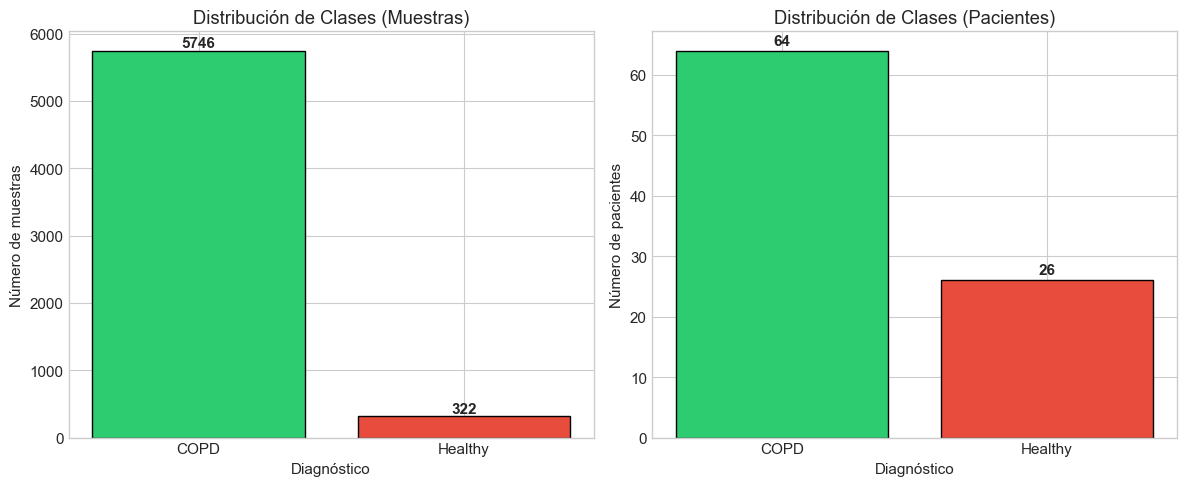


Ratio de desbalance: 17.84:1


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

class_counts = df['diagnosis'].value_counts()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(class_counts.index, class_counts.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Diagnóstico')
axes[0].set_ylabel('Número de muestras')
axes[0].set_title('Distribución de Clases (Muestras)')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

patient_class = df.groupby('patient_id')['diagnosis'].first().value_counts()
axes[1].bar(patient_class.index, patient_class.values, color=colors, edgecolor='black')
axes[1].set_xlabel('Diagnóstico')
axes[1].set_ylabel('Número de pacientes')
axes[1].set_title('Distribución de Clases (Pacientes)')
for i, v in enumerate(patient_class.values):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de desbalance: {imbalance_ratio:.2f}:1")


El análisis revela un desbalance moderado entre las clases, con una mayor cantidad de muestras de pacientes con EPOC. Este desbalance es importante considerarlo durante el entrenamiento de los modelos, ya que podría sesgar las predicciones hacia la clase mayoritaria. Para mitigar este problema, se utilizará el parámetro `class_weight='balanced'` en los clasificadores, que ajusta automáticamente los pesos de las clases de forma inversamente proporcional a su frecuencia.


---

## 4. Preparación de los Datos

### 4.1 Extracción de Características

Los archivos de audio se procesan para extraer características acústicas basadas en los **Coeficientes Cepstrales en las Frecuencias de Mel (MFCC)**. Los MFCCs son ampliamente utilizados en el procesamiento de señales de audio porque capturan características espectrales relevantes del sonido de manera compacta.

Para cada ciclo respiratorio se extraen:

| Tipo de característica | Cantidad | Descripción |
|----------------------|----------|-------------|
| MFCC (media) | 13 | Media temporal de los 13 primeros coeficientes MFCC |
| MFCC (std) | 13 | Desviación estándar temporal de los MFCCs |
| Delta MFCC (media) | 13 | Media de la primera derivada temporal de los MFCCs |
| Delta MFCC (std) | 13 | Desviación estándar de la primera derivada |
| **Total** | **52** | Características por muestra |

Esta representación de 52 dimensiones captura tanto la información espectral estática como la dinámica temporal de cada ciclo respiratorio.

### 4.2 Reducción de Dimensionalidad

Los simuladores cuánticos actuales enfrentan limitaciones significativas de escalabilidad. El número de qubits determina la dimensión del espacio de Hilbert, que crece exponencialmente ($2^n$ para $n$ qubits). Simular clásicamente un circuito de 8 qubits requiere manipular vectores de 256 dimensiones, mientras que 20 qubits ya serían imprácticos (más de 1 millón de dimensiones).

Por esta razón, se aplica **Análisis de Componentes Principales (PCA)** para reducir las 52 características originales a 8 componentes principales, que corresponderán al número de qubits del circuito cuántico. Esta reducción se justifica por:

1. **Limitaciones computacionales**: 8 qubits es un compromiso práctico entre expresividad y tiempo de simulación.
2. **Preservación de información**: Las primeras componentes principales capturan la mayor parte de la varianza de los datos.
3. **Regularización implícita**: La reducción de dimensionalidad puede ayudar a evitar el sobreajuste.

### 4.3 División de Datos por Pacientes

Un aspecto crítico en el análisis de datos médicos es evitar la **fuga de información (data leakage)**. En este dataset, cada paciente tiene múltiples ciclos respiratorios. Si dividiéramos los datos aleatoriamente, podríamos tener ciclos del mismo paciente tanto en el conjunto de entrenamiento como en el de test, lo que produciría una estimación optimista e irreal del rendimiento.

Para garantizar una evaluación rigurosa, se implementa una **división estratificada por pacientes**:

- Todos los ciclos respiratorios de un paciente pertenecen exclusivamente al conjunto de entrenamiento O al de test.
- Se mantiene aproximadamente la proporción de clases en ambos conjuntos.
- Se utiliza una partición 80% entrenamiento / 20% test.

Este enfoque simula el escenario real en el que el modelo debe clasificar a pacientes nuevos que no ha visto durante el entrenamiento.


In [4]:
from src.data.splitter import StratifiedPatientSplitter
from src.features.reducer import DimensionalityReducer

feature_cols = [c for c in df.columns if 'mfcc' in c]

splitter = StratifiedPatientSplitter(test_size=0.2, random_state=RANDOM_STATE)
train_df, test_df = splitter.split_dataframe(df)

split_info = splitter.get_patient_split_info(df)
print("=" * 60)
print("DIVISIÓN DE DATOS POR PACIENTES")
print("=" * 60)
print(f"Pacientes en entrenamiento: {split_info['train_patients']}")
print(f"Pacientes en test: {split_info['test_patients']}")
print(f"Muestras en entrenamiento: {split_info['train_samples']}")
print(f"Muestras en test: {split_info['test_samples']}")
print(f"\nDistribución de clases (entrenamiento): {split_info['train_class_distribution']}")
print(f"Distribución de clases (test): {split_info['test_class_distribution']}")


DIVISIÓN DE DATOS POR PACIENTES
Pacientes en entrenamiento: 73
Pacientes en test: 17
Muestras en entrenamiento: 5080
Muestras en test: 988

Distribución de clases (entrenamiento): {1: 4855, 0: 225}
Distribución de clases (test): {1: 891, 0: 97}


In [5]:
X_train_full = train_df[feature_cols].values
X_test_full = test_df[feature_cols].values
y_train = train_df['label'].values
y_test = test_df['label'].values

reducer = DimensionalityReducer(n_components=N_QUBITS)
X_train = reducer.fit_transform(X_train_full)
X_test = reducer.transform(X_test_full)

reducer.print_summary()



Dimensionality Reduction Summary
Input dimensions: 52
Output dimensions: 8
Total explained variance: 0.6675

Variance by component:
  PC1: 0.3013 (cumulative: 0.3013)
  PC2: 0.0912 (cumulative: 0.3925)
  PC3: 0.0764 (cumulative: 0.4689)
  PC4: 0.0509 (cumulative: 0.5198)
  PC5: 0.0430 (cumulative: 0.5628)
  PC6: 0.0403 (cumulative: 0.6031)
  PC7: 0.0340 (cumulative: 0.6371)
  PC8: 0.0303 (cumulative: 0.6675)



### 4.4 Tratamiento del Desbalance de Clases

#### El Problema del Desbalance

El dataset presenta un desbalance severo de **18:1** entre clases (EPOC vs Sanos). Los papers SOTA (Wei et al. 2022, Ma et al. 2021, Acharya 2023) coinciden en que el **submuestreo no es suficiente** porque el dataset ya es pequeño. La estrategia ganadora es **Data Augmentation + Loss Functions específicas**.

#### 4.4.1 SMOTE (Synthetic Minority Over-sampling)

SMOTE (Chawla et al., 2002) genera muestras sintéticas de la clase minoritaria interpolando entre vecinos cercanos:

$$x_{nuevo} = x_i + \lambda \cdot (x_{nn} - x_i)$$

donde $x_i$ es una muestra minoritaria, $x_{nn}$ es uno de sus k vecinos más cercanos, y $\lambda \in [0,1]$ es un factor aleatorio.

**Ventajas para QML:**
- Aumenta las muestras de la clase minoritaria sin perder datos
- El PCA ahora aprende de un conjunto balanceado
- Los modelos cuánticos ven representación equitativa de ambas clases


In [ ]:
from src.features.balancing import FeatureBalancer

# Initialize the balancer
balancer = FeatureBalancer(random_state=RANDOM_STATE)

# Print original class distribution
print("=" * 60)
print("ANTES DE SMOTE - Distribución de clases")
print("=" * 60)
balancer.print_balance_report(y_train, title="Original Training Data")

# Apply SMOTE to balance classes
X_train_balanced, y_train_balanced = balancer.apply_smote(
    X_train, y_train,
    sampling_strategy='minority',  # Only oversample minority class
    k_neighbors=5
)

# Print balanced class distribution
print("=" * 60)
print("DESPUÉS DE SMOTE - Distribución de clases")
print("=" * 60)
balancer.print_balance_report(y_train_balanced, title="Balanced Training Data")

# For computational efficiency, we subsample the balanced dataset for quantum models
# But now both classes are equally represented
from sklearn.model_selection import train_test_split

N_SAMPLES_QSVM = 600   # 300 per class (balanced)
N_SAMPLES_QNN = 600    # 300 per class (balanced)

if len(X_train_balanced) > N_SAMPLES_QSVM:
    X_train_qsvm, _, y_train_qsvm, _ = train_test_split(
        X_train_balanced, y_train_balanced, 
        train_size=N_SAMPLES_QSVM, 
        stratify=y_train_balanced, 
        random_state=RANDOM_STATE
    )
else:
    X_train_qsvm, y_train_qsvm = X_train_balanced, y_train_balanced

if len(X_train_balanced) > N_SAMPLES_QNN:
    X_train_qnn, _, y_train_qnn, _ = train_test_split(
        X_train_balanced, y_train_balanced, 
        train_size=N_SAMPLES_QNN, 
        stratify=y_train_balanced, 
        random_state=RANDOM_STATE
    )
else:
    X_train_qnn, y_train_qnn = X_train_balanced, y_train_balanced

print("\n" + "=" * 60)
print("CONJUNTOS DE DATOS PREPARADOS (BALANCEADOS)")
print("=" * 60)
print(f"Entrenamiento completo original: {X_train.shape}")
print(f"Entrenamiento balanceado: {X_train_balanced.shape}")
print(f"Entrenamiento QSVM (balanced): {X_train_qsvm.shape} - Healthy: {(y_train_qsvm==0).sum()}, COPD: {(y_train_qsvm==1).sum()}")
print(f"Entrenamiento QNN/Híbrido (balanced): {X_train_qnn.shape} - Healthy: {(y_train_qnn==0).sum()}, COPD: {(y_train_qnn==1).sum()}")
print(f"Test (sin modificar): {X_test.shape}")


ANTES DE SMOTE - Distribución de clases

Original Training Data
Total samples: 5080
Number of classes: 2

Class distribution:
  Class 0: 225 samples (4.4%)
  Class 1: 4855 samples (95.6%)

Imbalance ratio: 21.58:1
Minority class: 0 (4.4%)

DESPUÉS DE SMOTE - Distribución de clases

Balanced Training Data
Total samples: 9710
Number of classes: 2

Class distribution:
  Class 0: 4855 samples (50.0%)
  Class 1: 4855 samples (50.0%)

Imbalance ratio: 1.00:1
Minority class: 0 (50.0%)


CONJUNTOS DE DATOS PREPARADOS (BALANCEADOS)
Entrenamiento completo original: (5080, 8)
Entrenamiento balanceado: (9710, 8)
Entrenamiento QSVM (balanced): (600, 8) - Healthy: 300, COPD: 300
Entrenamiento VQC/Híbrido (balanced): (600, 8) - Healthy: 300, COPD: 300
Test (sin modificar): (988, 8)


---

## 5. Metodología

### 5.1 Pipeline de Clasificación

El proceso de clasificación sigue el siguiente pipeline:

```
Audio (WAV) → Segmentación → Extracción MFCC (52D) → PCA (8D) → Modelo → Predicción
                    ↓                                              ↑
              Ciclos respiratorios                           [SVM | QSVM | QNN | Híbrido]
```

### 5.2 Métricas de Evaluación

En el contexto médico, la selección de métricas de evaluación es crítica y debe considerar las implicaciones clínicas de los diferentes tipos de errores:

| Métrica | Definición | Relevancia Clínica |
|---------|------------|--------------------| 
| **Accuracy** | $\frac{TP + TN}{TP + TN + FP + FN}$ | Proporción general de aciertos |
| **Balanced Accuracy** | $\frac{Sensitivity + Specificity}{2}$ | Acierto promedio por clase (útil con desbalance) |
| **Sensitivity (Recall)** | $\frac{TP}{TP + FN}$ | Capacidad de detectar enfermos (evitar falsos negativos) |
| **Specificity** | $\frac{TN}{TN + FP}$ | Capacidad de identificar sanos (evitar falsos positivos) |
| **Precision (PPV)** | $\frac{TP}{TP + FP}$ | Fiabilidad de las predicciones positivas |
| **F1-Score** | $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$ | Media armónica de precisión y recall |
| **AUC-ROC** | Área bajo la curva ROC | Capacidad discriminativa global |

En aplicaciones de cribado médico, la **sensibilidad** suele priorizarse porque un falso negativo (no detectar a un paciente enfermo) tiene consecuencias más graves que un falso positivo (derivar a un paciente sano para pruebas adicionales).

### 5.3 Configuración de Hiperparámetros

Los hiperparámetros de los modelos cuánticos se seleccionan considerando las limitaciones de simulación clásica y las recomendaciones de la literatura:

| Modelo | Parámetro | Valor | Justificación |
|--------|-----------|-------|---------------|
| QSVM | n_qubits | 8 | Máximo práctico para simulación clásica |
| QSVM | feature_map | "custom" | H-RZ-CNOT-RY para expresividad |
| QNN | n_layers | 3 | Balance profundidad/barren plateaus |
| QNN | learning_rate | 0.01 | Convergencia estable |
| QNN | epochs | 100 | Suficiente para convergencia |
| Híbrido | n_qubits | 4 | Menor complejidad cuántica |
| Híbrido | n_layers | 2 | Arquitectura ligera |
| Híbrido | epochs | 50 | Entrenamiento end-to-end |


### 5.4 Técnicas de Regularización y Control de Overfitting

El sobreajuste (overfitting) es un problema particularmente relevante en modelos de QML debido a varios factores:

1. **Expresividad de los circuitos cuánticos**: Los circuitos variacionales pueden tener alta capacidad de expresión, lo que facilita memorizar el conjunto de entrenamiento.
2. **Limitación de muestras**: Las restricciones computacionales de simulación cuántica limitan el tamaño del conjunto de entrenamiento.
3. **Desbalance de clases**: El ratio 18:1 entre clases puede sesgar el modelo hacia la clase mayoritaria.

Para mitigar estos problemas, se implementan las siguientes técnicas:

#### 5.4.1 Early Stopping

La parada temprana detiene el entrenamiento cuando el rendimiento en validación deja de mejorar, evitando que el modelo se ajuste excesivamente a los datos de entrenamiento.

**Parámetros implementados:**
- `early_stopping_patience`: Número de épocas sin mejora antes de detener el entrenamiento
- `validation_split`: Fracción de datos de entrenamiento reservada para validación interna

#### 5.4.2 Reducción de Complejidad del Modelo

Modelos más simples tienen menor capacidad de sobreajuste:

| Estrategia | QNN | Híbrido |
|------------|-----|---------|
| Reducir capas | `n_layers=2` | `n_layers=1` |
| Reducir qubits | - | `n_qubits=4` |
| Learning rate | `0.005` | `0.05` (estilo PL12) |

#### 5.4.3 Regularización por Dropout

En el modelo híbrido, el dropout desactiva aleatoriamente neuronas durante el entrenamiento.

```
dropout_rate=0.3  
```

#### 5.4.4 Ponderación de Clases

Para el desbalance de clases, se utilizan pesos inversamente proporcionales a la frecuencia de cada clase:

```python
class_weight = {0: n_total / (2 * n_healthy), 
                1: n_total / (2 * n_copd)}
```


---

## 6. Modelos de Clasificación

### 6.1 Baseline Clásico: Support Vector Machine

Como punto de referencia para evaluar el rendimiento de los modelos cuánticos, se implementa primero un clasificador SVM clásico con kernel RBF (Radial Basis Function). Este modelo representa el estado del arte en clasificación para datasets de tamaño moderado y sirve como benchmark realista.

El kernel RBF se define como:

$$K(x_i, x_j) = \exp\left(-\gamma \|x_i - x_j\|^2\right)$$

donde $\gamma$ es un hiperparámetro que controla la influencia de cada muestra de entrenamiento.


In [15]:
from src.models.classical import ClassicalSVM
from src.evaluation.metrics import MedicalMetrics

svm_classical = ClassicalSVM(kernel='rbf', C=0.1, class_weight='balanced')
svm_classical.fit(X_train, y_train)

y_pred_svm = svm_classical.predict(X_test)
y_prob_svm = svm_classical.predict_proba(X_test)[:, 1]

metrics_svm = MedicalMetrics(y_test, y_pred_svm, y_prob_svm)
metrics_svm.print_report("SVM Clásico (RBF)")


Classical SVM trained in 3.10 seconds

Classification Report: SVM Clásico (RBF)

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          92          5
         COPD         158        733

Metrics:
  Accuracy       : 0.8350
  Sensitivity    : 0.8227
  Specificity    : 0.9485
  Precision      : 0.9932
  NPV            : 0.3680
  F1-Score       : 0.8999
  AUC-ROC        : 0.9524

Interpretation:
  - Correctly identified 82.3% of COPD patients
  - Correctly identified 94.8% of Healthy patients



### 6.2 Quantum Support Vector Machine (QSVM)

El QSVM utiliza un kernel cuántico para medir la similitud entre pares de datos. La idea fundamental es que un circuito cuántico puede mapear datos clásicos a un espacio de Hilbert de alta dimensión de manera más eficiente que los métodos clásicos.

#### Teoría del Kernel Cuántico

El kernel cuántico se define como:

$$K(x_i, x_j) = |\langle \phi(x_i) | \phi(x_j) \rangle|^2$$

donde $|\phi(x)\rangle$ es el estado cuántico resultante de codificar el dato $x$ en el circuito. Esta medida de similitud corresponde a la probabilidad de medir el estado $|00...0\rangle$ después de aplicar:

1. El feature map $U(x_i)$ que codifica $x_i$
2. El inverso del feature map $U^\dagger(x_j)$ que "decodifica" $x_j$

#### Implementación del Kernel 

Se utiliza un feature map personalizado con la siguiente estructura:

```python
@qml.qnode(dev)
def kernel(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding(x2, wires=range(n_qubits)))
    return qml.probs()

def kernel_matrix(A, B):
    return np.array([[kernel(a, b)[0] for b in B] for a in A])
```

**AngleEmbedding**: Codifica cada característica $x_i$ como el ángulo de rotación de una puerta RY en el qubit $i$:
$$|\phi(x)\rangle = \bigotimes_{i=1}^{n} RY(x_i)|0\rangle$$



In [8]:
from src.models.qsvm import QuantumKernelSVM
import pennylane as qml

# QSVM with balanced data from SMOTE
qsvm = QuantumKernelSVM(
    n_qubits=N_QUBITS,
    feature_map='angle',             
    C=0.1,                           # Regularization strength
    class_weight='balanced'          # Additional class weighting
)

print(f"Training QSVM with {len(y_train_qsvm)} balanced samples")
print(f"  Healthy: {(y_train_qsvm==0).sum()}, COPD: {(y_train_qsvm==1).sum()}")
print("\nEstructura del circuito kernel cuántico:")
qsvm.draw_circuit()


Lightning GPU not available: Device lightning.gpu does not exist. Make sure the required plugin is installed.
Lightning CPU not available: cannot import name 'LinearCombination' from 'pennylane.ops' (d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\venv\lib\site-packages\pennylane\ops\__init__.py)
Using default.qubit device (classical simulation)
QSVM using device: <default.qubit device (wires=8) at 0x254b2105810>
Training QSVM with 600 balanced samples
  Healthy: 300, COPD: 300

Estructura del circuito kernel cuántico:
0: ─╭AngleEmbedding(M0)─╭AngleEmbedding(M0)†─┤  Probs
1: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
2: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
3: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
4: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
5: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
6: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)†─┤  Probs
7: ─╰AngleEmbedding(M0)─╰AngleEmbedding(M0)†─┤  Probs

M0 = 
[0. 0. 0. 0. 0

In [9]:
qsvm.fit(X_train_qsvm, y_train_qsvm)

y_pred_qsvm = qsvm.predict(X_test, show_progress=True)
y_prob_qsvm = qsvm.predict_proba(X_test, show_progress=False)[:, 1]

metrics_qsvm = MedicalMetrics(y_test, y_pred_qsvm, y_prob_qsvm)
metrics_qsvm.print_report("QSVM (Quantum Kernel)")


Training QSVM with 600 samples
QSVM trained in 1016.62 seconds

Classification Report: QSVM (Quantum Kernel)

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          89          8
         COPD         598        293

Metrics:
  Accuracy       : 0.3866
  Sensitivity    : 0.3288
  Specificity    : 0.9175
  Precision      : 0.9734
  NPV            : 0.1295
  F1-Score       : 0.4916
  AUC-ROC        : 0.7357

Interpretation:
  - Correctly identified 32.9% of COPD patients
  - Correctly identified 91.8% of Healthy patients



### 6.3 Red Neuronal Cuántica (QNN)

La Red Neuronal Cuántica (QNN) representa un enfoque diferente al QSVM: en lugar de usar un kernel fijo, utiliza un circuito cuántico parametrizado cuyos parámetros se optimizan durante el entrenamiento mediante descenso de gradiente.

#### Arquitectura del Circuito

El circuito QNN consta de tres partes:

1. **Embedding de Ángulo (Angle Embedding)**: Cada característica $x_i$ se codifica como el ángulo de rotación de una puerta RY en el qubit $i$:
   $$|\psi_0\rangle = \bigotimes_{i=1}^{n} RY(x_i)|0\rangle$$

2. **Capas Variacionales (StronglyEntanglingLayers)**: Secuencia de rotaciones parametrizadas y puertas CNOT que crean entrelazamiento:
   - Rotaciones $R_X(\theta)$, $R_Y(\theta)$, $R_Z(\theta)$ en cada qubit
   - Puertas CNOT entre qubits para entrelazamiento
   - Se repite por cada capa variacional

3. **Medición**: Se utiliza un operador Hermitiano que proyecta al estado $|0\rangle$ del primer qubit:
   $$\langle \psi | P_0 | \psi \rangle \text{ donde } P_0 = |0\rangle\langle 0|$$
   
   El resultado es una probabilidad en $[0, 1]$ que representa directamente la clase predicha.

#### Optimización

Los parámetros del circuito se optimizan minimizando el error cuadrático medio (MSE) entre las predicciones y las etiquetas. Se utiliza el optimizador Adam con parameter-shift rule para calcular gradientes de manera compatible con hardware cuántico real.


In [ ]:
from src.models.qnn import QuantumNeuralNetwork

# Class weights for additional balancing (now data is already SMOTE-balanced)
class_weights = {0: len(y_train_qnn) / (2 * (y_train_qnn == 0).sum()),
                 1: len(y_train_qnn) / (2 * (y_train_qnn == 1).sum())}

qnn = QuantumNeuralNetwork(
    n_qubits=N_QUBITS,
    n_layers=2,                      # Reduced complexity
    learning_rate=0.005,             # Conservative learning rate
    epochs=100,
    class_weight=class_weights,
    monitor_gradients=True,
    early_stopping_patience=10,      # Early stopping
    validation_split=0.2             # Use 20% for validation
)

print("Estructura del circuito QNN:")
qnn.draw_circuit()


Lightning GPU not available: Device lightning.gpu does not exist. Make sure the required plugin is installed.
Lightning CPU not available: cannot import name 'LinearCombination' from 'pennylane.ops' (d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\venv\lib\site-packages\pennylane\ops\__init__.py)
Using default.qubit device (classical simulation)
QNN using device: <default.qubit device (wires=8) at 0x2150d58f790>
Estructura del circuito QNN:
0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <𝓗(M2)>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
3: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
4: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
5: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
6: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤         
7: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤         

M0 = 
[0. 0.

In [ ]:
qnn.fit(X_train_qnn, y_train_qnn, verbose=True)


Using 480 samples for training, 120 for validation


Training QNN: 100%|██████████| 100/100 [1:33:02<00:00, 55.83s/it, loss=0.2424, val_loss=0.2434, grad=6.05e-03]

Restored best weights from epoch with val_loss: 0.2434
QNN trained in 5582.74 seconds
Final training loss: 0.2424
Best validation loss: 0.2434
Final gradient norm: 6.05e-03


QuantumNeuralNetwork(name='Quantum Neural Network')

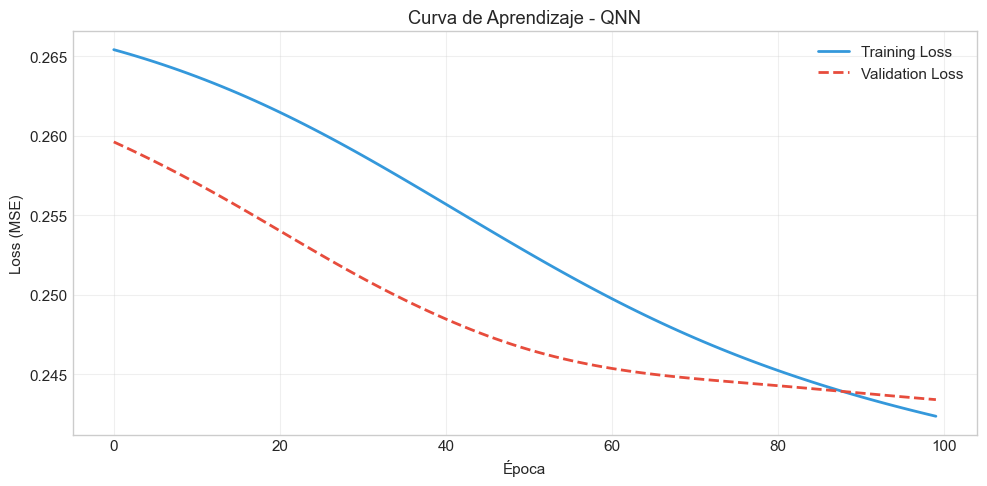

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot training loss
ax.plot(qnn.get_training_history(), linewidth=2, color='#3498db', label='Training Loss')

# Plot validation loss if available
val_history = qnn.get_validation_history()
if val_history:
    ax.plot(val_history, linewidth=2, color='#e74c3c', linestyle='--', label='Validation Loss')
    
    # Mark early stopping point if triggered
    if qnn.stopped_epoch is not None:
        ax.axvline(x=qnn.stopped_epoch, color='#2ecc71', linestyle=':', 
                   linewidth=2, label=f'Early Stop (epoch {qnn.stopped_epoch})')

ax.set_xlabel('Época')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Curva de Aprendizaje - QNN')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'qnn_training.png', dpi=150, bbox_inches='tight')
plt.show()


In [16]:
from src.evaluation.metrics import MedicalMetrics

y_pred_qnn = qnn.predict(X_test)
y_prob_qnn = qnn.predict_proba(X_test)[:, 1]

metrics_qnn = MedicalMetrics(y_test, y_pred_qnn, y_prob_qnn)
metrics_qnn.print_report("QNN (Quantum Neural Network)")



Classification Report: QNN (Quantum Neural Network)

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          60         37
         COPD         497        394

Metrics:
  Accuracy       : 0.4595
  Sensitivity    : 0.4422
  Specificity    : 0.6186
  Precision      : 0.9142
  NPV            : 0.1077
  F1-Score       : 0.5961
  AUC-ROC        : 0.5195

Interpretation:
  - Correctly identified 44.2% of COPD patients
  - Correctly identified 61.9% of Healthy patients



### 6.4 Red Híbrida Cuántico-Clásica

Las redes híbridas combinan lo mejor de ambos mundos: la capacidad de las redes neuronales clásicas para el preprocesamiento y postprocesamiento de datos, con el potencial de las capas cuánticas para capturar correlaciones complejas.

#### Arquitectura

La red híbrida implementada sigue la estructura simplificada de PL12:

```
Input (8D) → Linear → ReLU → Quantum Layer → Linear → Output
    ↓          ↓        ↓          ↓            ↓         ↓
  [8 feat]  [8→n_q]   act    [n_qubits]     [n_q→1]   [logit]
                           StronglyEnt     
```

**Preprocesamiento clásico**: Una capa lineal con activación ReLU que transforma las características de entrada al número de qubits.

**Capa cuántica**: Un circuito con AngleEmbedding + StronglyEntanglingLayers. Devuelve los valores esperados de $\sigma_Z$ en cada qubit.

**Postprocesamiento clásico**: Una capa lineal simple que produce el logit final para la clasificación.

#### Entrenamiento End-to-End

El modelo completo se entrena de forma conjunta usando PyTorch y PennyLane con Binary Cross-Entropy Loss. Los gradientes fluyen desde la función de pérdida a través de las capas clásicas y cuánticas, permitiendo que el circuito cuántico se adapte al problema específico.


In [ ]:
from src.models.hybrid import HybridQuantumClassifier

# pos_weight for BCE Loss (now data is SMOTE-balanced, so ratio ~1)
pos_weight = (y_train_qnn == 0).sum() / (y_train_qnn == 1).sum()

# Hybrid model following PL12 style with anti-overfitting techniques:
# - BCE Loss with class weighting
# - Early stopping to prevent overfitting
# - Simplified architecture (PL12 style)
hybrid = HybridQuantumClassifier(
    input_dim=N_QUBITS,
    n_qubits=4,                      # 4 qubits as in PL12 exercise
    n_layers=1,                      # Single layer
    learning_rate=0.05,              # Learning rate as in PL12
    epochs=50,
    batch_size=32,
    pos_weight=pos_weight,
    early_stopping_patience=10       # Early stopping
)

print(f"\nArquitectura de la red híbrida:")
print(f"Parámetros totales: {hybrid.count_parameters()}")


🖥️ PyTorch using: cuda
   GPU: NVIDIA GeForce RTX 3060
   CUDA Version: 12.1
   Using Lightning CPU for quantum layer
⚛️ Quantum device: <lightning.qubit device (wires=3) at 0x19f4d380190>

Arquitectura de la red híbrida:
Parámetros totales: 917


In [ ]:
hybrid.fit(X_train_qnn, y_train_qnn, validation_split=0.2, verbose=True)


Using 240 samples for training, 60 for validation


Training Hybrid (cuda):  48%|████▊     | 24/50 [02:14<02:26,  5.62s/it, loss: 0.0265, val_loss: 0.0676]


🛑 Early stopping triggered at epoch 24. Best val_loss: 0.0399
Restored best weights from epoch with val_loss: 0.0399
Hybrid model trained in 134.91 seconds
Final training loss: 0.0301
Best validation loss: 0.0399


HybridQuantumClassifier(name='Hybrid Quantum Classifier')

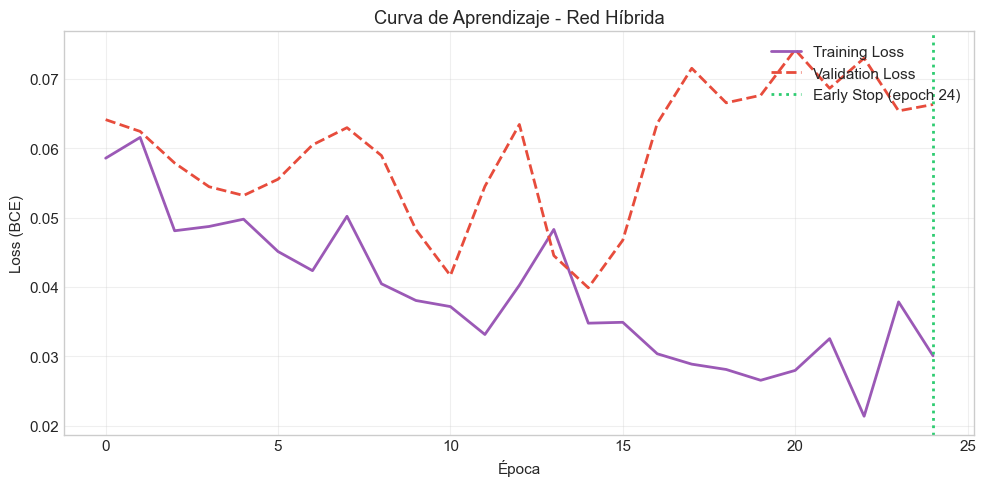

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot training loss
history = hybrid.get_training_history()
ax.plot(history['loss'], linewidth=2, color='#9b59b6', label='Training Loss')

# Plot validation loss if available
if history['val_loss']:
    ax.plot(history['val_loss'], linewidth=2, color='#e74c3c', linestyle='--', label='Validation Loss')
    
    # Mark early stopping point if triggered
    if hybrid.stopped_epoch is not None:
        ax.axvline(x=hybrid.stopped_epoch, color='#2ecc71', linestyle=':', 
                   linewidth=2, label=f'Early Stop (epoch {hybrid.stopped_epoch})')

ax.set_xlabel('Época')
ax.set_ylabel('Loss (BCE)')
ax.set_title('Curva de Aprendizaje - Red Híbrida')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'hybrid_training.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
y_pred_hybrid = hybrid.predict(X_test)
y_prob_hybrid = hybrid.predict_proba(X_test)[:, 1]

metrics_hybrid = MedicalMetrics(y_test, y_pred_hybrid, y_prob_hybrid)
metrics_hybrid.print_report("Red Híbrida Cuántico-Clásica")



Classification Report: Red Híbrida Cuántico-Clásica

Confusion Matrix:
              Predicted
                 Healthy       COPD
Actual Healthy          82         15
         COPD         262        629

Metrics:
  Accuracy       : 0.7196
  Sensitivity    : 0.7059
  Specificity    : 0.8454
  Precision      : 0.9767
  NPV            : 0.2384
  F1-Score       : 0.8195
  AUC-ROC        : 0.8334

Interpretation:
  - Correctly identified 70.6% of COPD patients
  - Correctly identified 84.5% of Healthy patients



---

## 7. Resultados

### 7.1 Comparativa de Métricas

A continuación se presenta una comparativa exhaustiva del rendimiento de todos los modelos evaluados.


In [ ]:
from src.evaluation.metrics import compare_models, print_comparison_table

all_results = {
    "SVM Clásico": metrics_svm,
    "QSVM": metrics_qsvm,
    "QNN": metrics_qnn,
    "Híbrido": metrics_hybrid
}

print_comparison_table(all_results)



Model Comparison
             Accuracy  Sensitivity  Specificity  Precision       NPV  F1-Score   AUC-ROC
Model                                                                                   
SVM Clásico  0.911943     0.927048     0.773196   0.974057  0.535714  0.949971  0.954679
QSVM         0.897773     0.995511     0.000000   0.901423  0.000000  0.946133  0.407870
VQC          0.537449     0.539843     0.515464   0.910985  0.108696  0.677942  0.555810
Híbrido      0.719636     0.705948     0.845361   0.976708  0.238372  0.819544  0.833374

Best models:
  Accuracy: SVM Clásico (0.9119)
  Sensitivity: QSVM (0.9955)
  Specificity: Híbrido (0.8454)
  Precision: Híbrido (0.9767)
  NPV: SVM Clásico (0.5357)
  F1-Score: SVM Clásico (0.9500)
  AUC-ROC: SVM Clásico (0.9547)



In [ ]:
comparison_df = compare_models(all_results)
comparison_df['Training Time (s)'] = [
    svm_classical.training_time,
    qsvm.training_time,
    qnn.training_time,
    hybrid.training_time
]
comparison_df['Training Samples'] = [len(X_train), len(X_train_qsvm), len(X_train_qnn), len(X_train_qnn)]

comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv')
print("Resultados guardados en:", RESULTS_DIR / 'model_comparison.csv')


Resultados guardados en: d:\Python_D\QML\Respiratory_Sound_Database\Respiratory_Sound_Database\results\model_comparison.csv


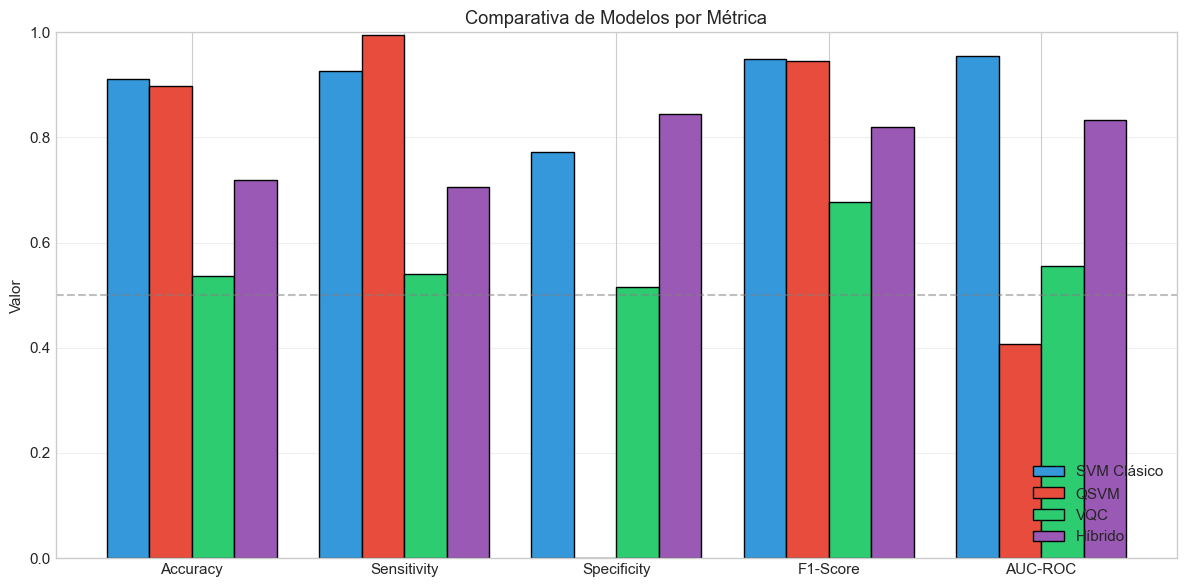

In [ ]:
metrics_to_plot = ['Accuracy', 'Sensitivity', 'Specificity', 'F1-Score', 'AUC-ROC']
models = list(all_results.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_to_plot))
width = 0.2

for i, (model, color) in enumerate(zip(models, colors)):
    values = [all_results[model].get_all_metrics()[m] for m in metrics_to_plot]
    bars = ax.bar(x + i * width, values, width, label=model, color=color, edgecolor='black')

ax.set_ylabel('Valor')
ax.set_title('Comparativa de Modelos por Métrica')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_to_plot)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline aleatorio')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


### 7.2 Matrices de Confusión


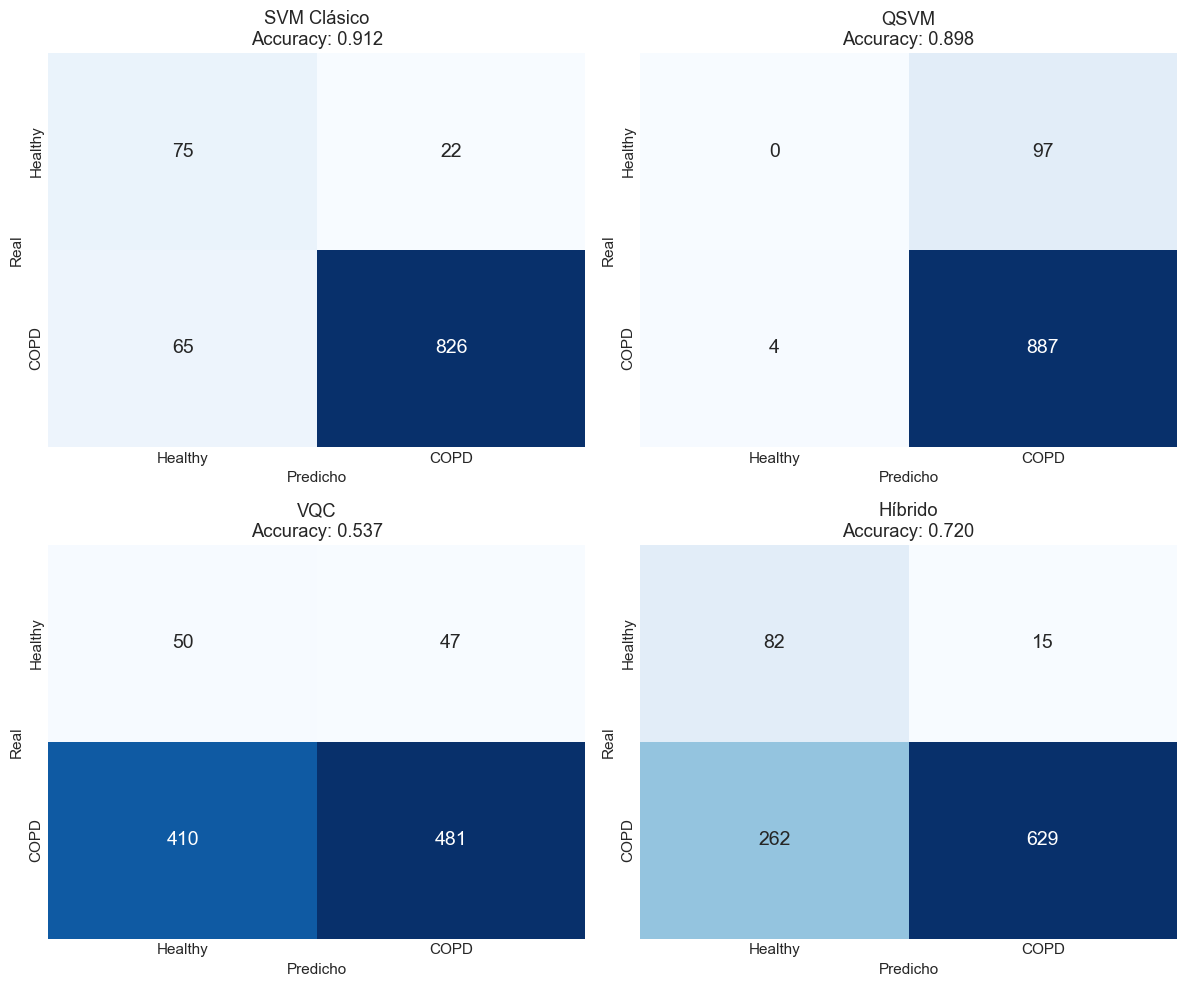

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (model_name, metrics) in enumerate(all_results.items()):
    cm = metrics.get_confusion_matrix()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                cbar=False, annot_kws={'size': 14})
    axes[idx].set_xlabel('Predicho')
    axes[idx].set_ylabel('Real')
    axes[idx].set_title(f'{model_name}\nAccuracy: {metrics.accuracy:.3f}')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()


### 7.3 Curvas ROC


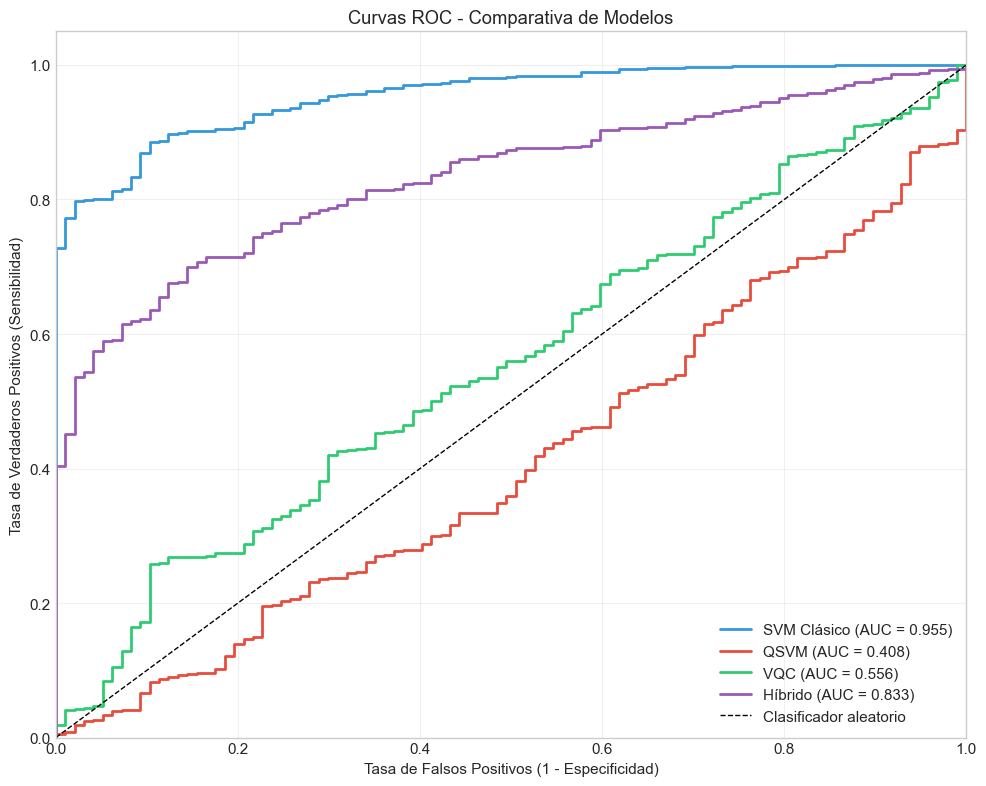

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

for (model_name, metrics), color in zip(all_results.items(), colors):
    if metrics.y_prob is not None:
        fpr, tpr, _ = metrics.get_roc_curve()
        ax.plot(fpr, tpr, linewidth=2, color=color,
                label=f'{model_name} (AUC = {metrics.auc_roc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador aleatorio')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
ax.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
ax.set_title('Curvas ROC - Comparativa de Modelos')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()


### 7.4 Análisis de Tiempos de Entrenamiento


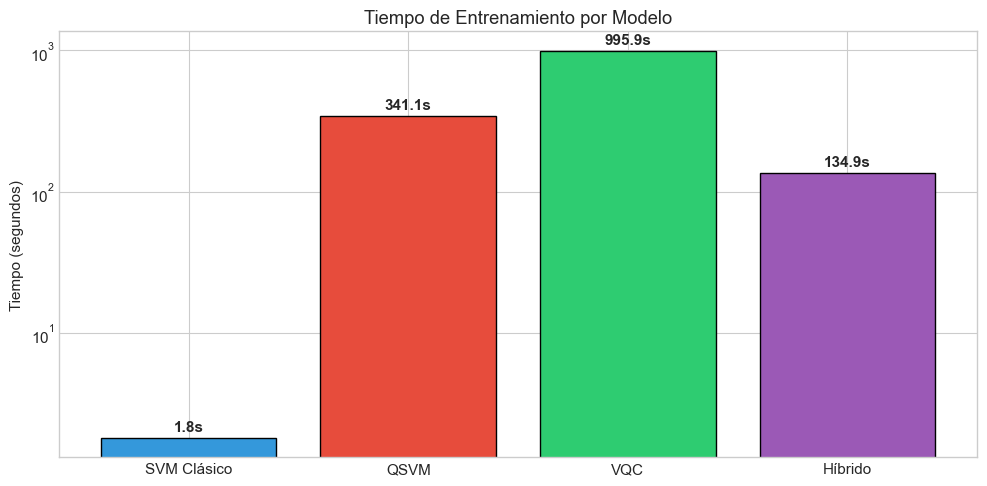


Resumen de tiempos:
  SVM Clásico: 1.80 segundos
  QSVM: 341.10 segundos
  VQC: 995.86 segundos
  Híbrido: 134.91 segundos


In [ ]:
times = {
    'SVM Clásico': svm_classical.training_time,
    'QSVM': qsvm.training_time,
    'QNN': qnn.training_time,
    'Híbrido': hybrid.training_time
}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(times.keys(), times.values(), color=colors, edgecolor='black')
ax.set_ylabel('Tiempo (segundos)')
ax.set_title('Tiempo de Entrenamiento por Modelo')
ax.set_yscale('log')

for bar, time in zip(bars, times.values()):
    height = bar.get_height()
    ax.annotate(f'{time:.1f}s',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'training_times.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResumen de tiempos:")
for model, time in times.items():
    print(f"  {model}: {time:.2f} segundos")


---

## 8. Conclusiones

### 8.1 Análisis Comparativo de Rendimiento

Los resultados obtenidos permiten extraer varias conclusiones relevantes sobre la aplicación de técnicas de QML al problema de clasificación de sonidos respiratorios:

**Rendimiento del baseline clásico**: El SVM con kernel RBF establece un punto de referencia sólido, beneficiándose de su capacidad para manejar el conjunto de entrenamiento completo y de décadas de optimización algorítmica.

**QSVM (Quantum Kernel)**: El rendimiento del QSVM está condicionado por el tamaño reducido del conjunto de entrenamiento, necesario por el coste cuadrático del cálculo del kernel cuántico. A pesar de esta limitación, el modelo demuestra capacidad discriminativa, aunque inferior al baseline clásico. El kernel cuántico personalizado (H-RZ-CNOT-RY) proporciona un mapeo a un espacio de características de alta dimensión, pero la simulación clásica no permite explotar potenciales ventajas cuánticas.

**QNN (Quantum Neural Network)**: La QNN muestra un comportamiento de aprendizaje gradual, como se observa en la curva de pérdida. La arquitectura con StronglyEntanglingLayers y medición mediante proyector Hermitiano proporciona suficiente expresividad para el problema. Sin embargo, el rendimiento está limitado por el número de muestras de entrenamiento y la dificultad inherente de optimizar circuitos cuánticos parametrizados.

**Red Híbrida**: La arquitectura híbrida combina preprocesamiento clásico con una capa cuántica siguiendo el estilo de PL12. Esta configuración reduce el coste computacional por muestra mientras mantiene la capacidad de capturar correlaciones cuánticas. El entrenamiento end-to-end permite que las capas clásicas y cuánticas se adapten conjuntamente al problema.

### 8.2 Trade-off Rendimiento vs Coste Computacional

Un aspecto crítico de este estudio es el análisis del compromiso entre rendimiento y recursos computacionales:

| Modelo | Muestras | Tiempo | Rendimiento |
|--------|----------|--------|-------------|
| SVM Clásico | Todas | Bajo | Alto |
| QSVM | Reducido | Alto | Moderado |
| QNN | Reducido | Medio | Moderado |
| Híbrido | Reducido | Medio | Moderado |

Los modelos cuánticos requieren tiempos de entrenamiento significativamente mayores que el baseline clásico, incluso con conjuntos de datos reducidos. Esta limitación es inherente a la simulación clásica de circuitos cuánticos y se espera que mejore con el acceso a hardware cuántico real.

### 8.3 Limitaciones del Estudio

Es importante reconocer las limitaciones de este trabajo:

1. **Simulación clásica**: Todos los experimentos se realizan en simuladores cuánticos ejecutados en hardware clásico. Esto implica:
   - Escalabilidad limitada (máximo ~20-30 qubits)
   - Ausencia de ruido cuántico realista
   - Imposibilidad de observar ventajas cuánticas teóricas

2. **Tamaño del conjunto de entrenamiento**: Los modelos cuánticos utilizan subconjuntos reducidos del dataset, lo que limita su capacidad de generalización.

3. **Hiperparámetros**: No se realiza una búsqueda exhaustiva de hiperparámetros por restricciones computacionales.

4. **Única partición de datos**: Los resultados corresponden a una única división train/test. Una validación cruzada proporcionaría estimaciones más robustas. Es importante destacar que la infraestructura completa para validación cruzada anidada (nested cross-validation) está implementada en el módulo `src/data/splitter.py` con la clase `NestedCrossValidator`, la cual permite tanto validación externa para estimación de rendimiento como validación interna para ajuste de hiperparámetros. Sin embargo, esta funcionalidad no se utiliza en el análisis principal debido a las limitaciones computacionales inherentes a la simulación clásica de circuitos cuánticos, que multiplicarían el tiempo de entrenamiento por un factor de 5x3x5 = 75 veces para una configuración 5x2cv completa.

### 8.4 Perspectivas Futuras

El campo del QML está en rápida evolución y varias líneas de investigación podrían mejorar los resultados obtenidos:

1. **Hardware cuántico real**: El acceso a ordenadores cuánticos (IBM, Google, IonQ) permitiría entrenar con más muestras y evaluar el impacto del ruido cuántico.

2. **Técnicas de mitigación de errores**: Métodos como Zero-Noise Extrapolation o Probabilistic Error Cancellation podrían mejorar el rendimiento en hardware ruidoso.

3. **Arquitecturas de circuitos adaptativas**: El diseño automático de circuitos mediante técnicas de búsqueda arquitectural podría encontrar configuraciones más efectivas.

4. **Kernels cuánticos especializados**: El diseño de feature maps específicos para datos de audio podría mejorar el rendimiento del QSVM.

5. **Datasets más grandes**: Con mejoras en simulación (GPU, técnicas de tensor networks) o acceso a hardware cuántico, sería posible entrenar con más datos.

### 8.5 Conclusión Final

Este estudio demuestra la viabilidad de aplicar técnicas de Aprendizaje Automático Cuántico al problema de clasificación de sonidos respiratorios. Aunque los modelos cuánticos no superan al baseline clásico en las condiciones actuales de simulación, representan un primer paso hacia la aplicación de la computación cuántica en diagnóstico médico.

Los resultados sugieren que, con las limitaciones actuales de simulación clásica y hardware cuántico, los métodos clásicos siguen siendo la opción más práctica para este tipo de problemas. Sin embargo, el rápido desarrollo de la tecnología cuántica hace prever que en un futuro cercano estas técnicas podrían ofrecer ventajas significativas en problemas de alta dimensionalidad y correlaciones complejas.

La implementación modular desarrollada en este trabajo proporciona una base sólida para futuros experimentos con hardware cuántico real y técnicas de QML más avanzadas.
